In [29]:
from pathlib import Path
from brainlit.utils.Neuron_trace import NeuronTrace
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph, compute_parameterization
from scipy.interpolate import splprep, BSpline, CubicHermiteSpline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from scipy.interpolate import splev
from brainlit.map_neurons.map_neurons import DiffeomorphismAction, transform_GeometricGraph, compute_derivs
import pandas as pd
import numpy as np
import h5py
from brainlit.map_neurons.map_neurons import CloudReg_Transform
from scipy.spatial.distance import cosine
from scipy.stats import wilcoxon, pearsonr, linregress
from tqdm import tqdm
from cloudvolume import CloudVolume
from similaritymeasures import frechet_dist
from frechetdist import frdist
import seaborn as sns
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import time
from cloudvolume.exceptions import SkeletonDecodeError
import pickle
from copy import deepcopy
#%matplotlib widget

## Toy example

In [ ]:
dict = {"x": [0, 0], "y": [-1, 1], "z": [0, 0], "sample": [1,2], "parent": [-1, 1]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)

### Custom transformation

In [ ]:
#only move points
class Triangle_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        #if x1 between 

        tophalf = np.logical_and(position[:,1] >= 0, position[:,1] <= 1)
        bottomhalf = np.logical_and(position[:,1] < 0, position[:,1] >= -1)

        newvals = position[tophalf]
        newvals[:,0] += position[tophalf][:,1]-1
        transformed_position[tophalf] = newvals

        newvals = position[bottomhalf]
        newvals[:,0] += -1*position[bottomhalf][:,1]-1
        transformed_position[bottomhalf] = newvals
        
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv

#move points and derivatives
class Triangle_1(Triangle_0):
    def __init__(self):
        pass
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()

        transformed_deriv[np.logical_and(position[:,1] >= 0, position[:,1] <= 1)] = np.matmul(np.array([[1,1,0],[0,1,0],[0,0,1]]), deriv[np.logical_and(position[:,1] >= 0, position[:,1] <= 1)].T).T
        transformed_deriv[np.logical_and(position[:,1] >= -1, position[:,1] < 0)] = np.matmul(np.array([[1,-1,0],[0,1,0],[0,0,1]]), deriv[np.logical_and(position[:,1] >= -1, position[:,1] < 0)].T).T
        return transformed_deriv


In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

# plot curve
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    ax.scatter(pts[0], pts[1], pts[2], c='red', s=20)

    u = np.arange(u[0], u[-1]+0.1, 0.1)
    pts = splev(u, tck)

    ax.plot(pts[0], pts[1], pts[2], linestyle='-',color='red',linewidth=0.8, label="Simple Curve")

# plot field
diff = Triangle_0()

x, y, z = np.meshgrid(np.arange(-1, 0.7, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [np.arange(0, 1, 1)]) #-0.5, 0.6, 1


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)



ax.quiver(x, y, z, u, v, w, length=0.2, label="Scaled Displacement Field")
ax.axes.set_xlim3d(left=-1, right=0.5) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-0.5, top=0.5) 
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

#plt.title("Displacement Field")
plt.legend(fontsize=17)
plt.show()

### Perform transformation

In [ ]:
diff = Triangle_1()
G_transformed = deepcopy(G)
G_transformed = transform_GeometricGraph(G_transformed, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

#act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    u = np.arange(u[0], u[-1]+0.1, 0.1)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, c='red', label="Continuous Mapping (Ground Truth)")

    u = np.arange(u[0], u[-1]+0.1, u[-1]-u[0])
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 0th Order", c='blue')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], c='red', s=20)

#act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.1, 0.1)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 1st Order", c='green')
ax.axes.set_xlim3d(left=-1, right=0.5) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-0.5, top=0.5) 
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
#plt.title("Comparing 0th and 1st Order Transformations")
plt.legend(fontsize = 17)
plt.show()

## Toy Example multiple segments

In [ ]:
dict = {"x": [0, -0.7, -1, -1], "y": [-1, -0.25, 0.25, 1], "z": [0, 0, 0.25, 1], "sample": [1,2, 3, 4], "parent": [-1, 1, 2, 3]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)

### Gaussian warp

In [ ]:
from scipy.stats import norm

#only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        transformed_position[:,0] += norm.pdf(transformed_position[:,1], scale = 0.5)
        
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv

#move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self):
        pass
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[0,1] = norm.pdf(pos[1], scale = 0.5)*(-4*pos[1])
            transformed_deriv[i,:] = np.matmul(J, d).T

        return transformed_deriv


In [ ]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Simple Curve", c="red")
    ax.scatter(pts[0], pts[1], pts[2], c="red")

    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)

    #ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

# Generate transformation
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1, 0.4, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [0.5])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)

ax.quiver(x, y, z, u, v, w, length=0.2, label="Scaled Displacement Field")

ax.legend(fontsize=17)
ax.axes.set_xlim3d(left=-1, right=0.25) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

In [ ]:
diff = Gaussian_1()
G_transformed = deepcopy(G)
G_transformed = transform_GeometricGraph(G_transformed, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

#act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    tck[2] = 1

    #dense spline points
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Continuous Mapping (Ground Truth)", c='red')

    #trace points only
    u = spline[1]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 0th Order", c='blue')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], c='red')

#act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 1st Order", c='green')
    
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.legend(fontsize=17)
ax.axes.set_xlim3d(left=-1, right=0.25) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

## CloudReg + Toy Neuron
warning: uses old derivative method (spline)

In [ ]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/example_cloudreg/8604_Ch_561_registration/downloop_1_v.mat",
"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/example_cloudreg/8604_Ch_561_registration/downloop_1_A.mat")

og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

print(f"{xmin}:{xmax},{ymin}:{ymax},{zmin}:{zmax}")

xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(og_coords[:,0],og_coords[:,1],og_coords[:,2], label="Grid (Target Space)")

ax = fig.gca(projection='3d')
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), length=500, label="Tangent vectors (Target Space)")

new_coords = ct.evaluate(og_coords)
print(f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}")
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1,1,1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(new_coords[:,0],new_coords[:,1],new_coords[:,2], label="Grid (Template Space)")
ax.quiver(new_coords[:,0],new_coords[:,1],new_coords[:,2], new_derivs[:,0],new_derivs[:,1],new_derivs[:,2], length=500, color='orange', label="Tangent vectors (Template Space)")
ax.legend()

In [ ]:
dict = {"x": [0, -2000, -4000], "y": [0, -2000, 2000], "z": [-4000, -2000, 0], "sample": [1,2, 3], "parent": [-1, 1, 2]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)
spline_tree = G.fit_spline_tree_invariant()
G.compute_derivs()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")

ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), linestyle='-',linewidth=0.8, color='orange')

G_transformed = deepcopy(G)
G_tranformed = transform_GeometricGraph(G_transformed, ct)
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G.spline_tree
for node in tqdm(spline_tree.nodes, desc="Target space"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Toy neuron (Target Space)")
    derivs = splev(u, tck, der = 1)
    ax.quiver(pts[0], pts[1], pts[2], derivs[0], derivs[1], derivs[2],length=500, color='orange')

    # spline
    u2 = np.arange(u[0], u[-1]+0.01, 0.01)
    pts2 = splev(u2, tck)
    #ax.plot(pts2[0], pts2[1], pts2[2], linestyle='-',linewidth=0.8, label="Spline (Target Space)")
ax.set_title("Target Space")
ax.legend()

ax = fig.add_subplot(1, 2, 2, projection="3d")
for node in tqdm(spline_tree.nodes, desc="Template space"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    #dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1]+0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color='blue', label="Dense Points Lines")

    #dense spline points
    u_spline = np.arange(u[0], u[-1]+0.01, 0.01)
    pts_spline = splev(u_spline, tck)
    pts_spline = np.stack(pts_spline, axis=1)
    trans_pts = ct.evaluate(pts_spline)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color="orange", label="Dense Points Spline")

    #Transformed points
    trans_pts = ct.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="0th Order Mapping", color='green')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color="orange")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)
    ax.quiver(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], trans_derivs[:,0], trans_derivs[:,1], trans_derivs[:,2],length=500, color="orange")


#act on derivatives
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="1st Order Mapping", color='red')
ax.set_title("Template Space")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

ax.legend()
plt.show()

## Example transforming ng coordinates (matt sample) to atlas cords

In [ ]:
vol = CloudVolume("precomputed://https://dlab-colm.neurodata.io/2022_02_02/8604/Ch_647")
vol_atlas = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
pt = np.array([[5344, 2244, 1500]])

res = np.array(vol.resolution)/1000
shp = np.array(vol.shape)[:3]
og = np.multiply(shp-1,res)/2
pt = pt*res - og
print(f"New point: {pt} for og: {og}")

new_pt = ct.apply_affine(pt)

res_atlas = np.array(vol_atlas.resolution)/1000
shp_atlas = np.array(vol_atlas.shape)[:3]
og_atlas = np.multiply(shp_atlas-1,res_atlas)/2

(new_pt+og_atlas)/res_atlas

## CloudReg + Real Neuron

In [2]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_v.mat",
"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_A.mat")

integrating velocity field: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_10245/1235121092.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


average squared deformation 80.3881172540377
average 1-cosine between derivatives 4.0548223598762395e-06


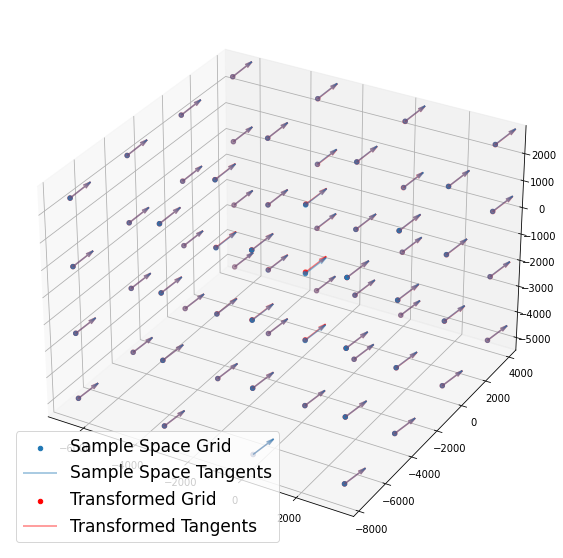

In [3]:
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(og_coords[:,0],og_coords[:,1],og_coords[:,2], label="Sample Space Grid")

ax = fig.gca(projection='3d')
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), length=500, label="Sample Space Tangents", alpha=0.5)

new_coords = ct.evaluate(og_coords)
print(f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}")
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1,1,1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(new_coords[:,0],new_coords[:,1],new_coords[:,2], label="Transformed Grid", color='red')
ax.quiver(new_coords[:,0],new_coords[:,1],new_coords[:,2], new_derivs[:,0],new_derivs[:,1],new_derivs[:,2], length=500, color='red', label="Transformed Tangents", alpha=0.5)
#ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
ax.legend(fontsize=17)

1st order mappings: 100%|██████████| 257/257 [00:00<00:00, 31072.50it/s]


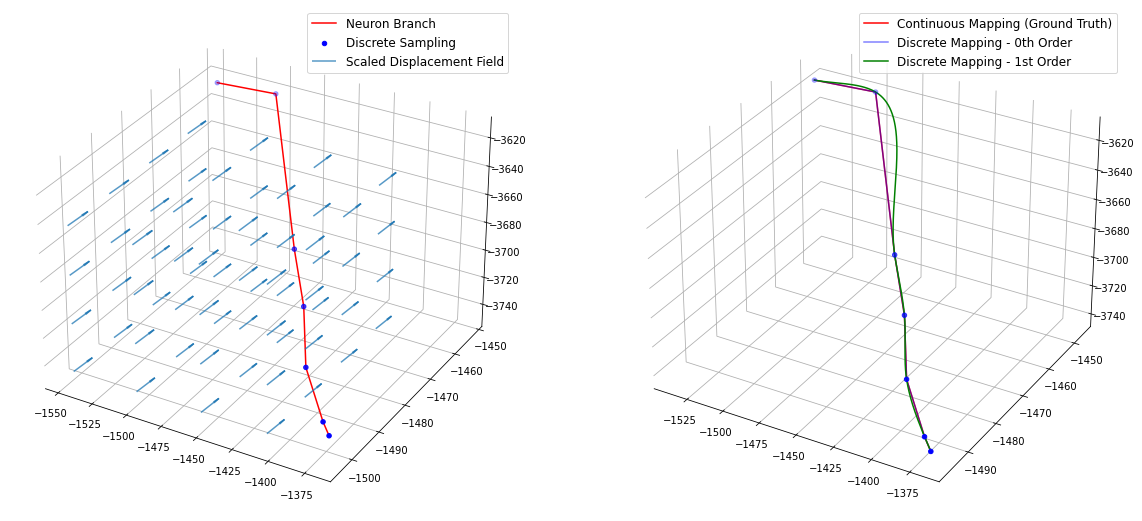

[312.32650457 216.53946576  51.51496608]


In [8]:
#1,22; 4,179
neuron_id = 1
branch_id = 97


vol_im = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/ch1_otsu_iso")
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution)/1000
origin_im = (shp[:3] - 1) * res_im / 2

vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/axons")
shp = np.array(vol.shape)
res_atlas = np.array(vol.resolution)/1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices/1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection="3d")

#ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), linestyle='-',linewidth=0.8)
G_transformed = deepcopy(G)
G_transformed = transform_GeometricGraph(G_transformed, ct)
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle='-', label=label, color="red")
    ax.scatter(pts[0], pts[1], pts[2], linestyle='-', label="Discrete Sampling", color="blue")
    #ax.scatter(pts[0], pts[1], pts[2], color="red")
    derivs = splev(u, tck, der = 1)
    #ax.quiver(pts[0], pts[1], pts[2], derivs[0], derivs[1], derivs[2],length=500, color='orange')

    # # spline
    # u2 = np.arange(u[0], u[-1]+0.01, 0.01)
    # pts2 = splev(u2, tck)
    # if i == 0 or node == branch_id:
    #     label = "Spline"
    # else:
    #     label = None
    # ax.plot(pts2[0], pts2[1], pts2[2], linestyle='-',linewidth=0.8, label=label, color="red")

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], displacements[:,0],displacements[:,1],displacements[:,2], length=1, label="Scaled Displacement Field", alpha=0.75) #length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


#ax.scatter(soma[0],soma[1],soma[2], c='blue', s=5)
#ax.set_title("Target Space")
ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)


    #dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1]+0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-', color='red', label=label)

    # #dense spline points
    # u_spline = np.arange(u[0], u[-1]+0.01, 0.01)
    # pts_spline = splev(u_spline, tck)
    # pts_spline = np.stack(pts_spline, axis=1)
    # trans_pts = ct.evaluate(pts_spline)
    # if i == 0:
    #     label = "Dense Points Spline"
    # else:
    #     label = None
    # ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color="orange", label=label)

    #Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-', label=label, color='blue', alpha = 0.5)
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color='blue')
    #ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color='red')
    #ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color="orange")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)
    #ax.quiver(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], trans_derivs[:,0], trans_derivs[:,1], trans_derivs[:,2],length=500, color="orange")

#act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-', label=label, color='green')

#ax.scatter(soma[0],soma[1],soma[2], c='blue', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
#ax.set_title("Template Space")
ax.legend(fontsize=12)

plt.show()

print((soma + origin_atlas)/res_atlas)

## Compute error

In [15]:
vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/axons")
shp = np.array(vol.shape)
res_im = np.array(vol.resolution)/1000
origin_im = (shp[:3] - 1) * res_im / 2

valid_ids = []
for i in range(100):
    try:
        vol.skeleton.get(i)
    except SkeletonDecodeError:
        continue
    valid_ids.append(i)

print(f"Valid IDs: {valid_ids}")

Valid IDs: [1, 4, 11, 12, 13, 14, 20, 35, 40, 45, 48, 49, 51, 53, 59, 60, 65]


In [16]:
truths = []
errors = []
methods = []

spacing = 2
plot_branches = False
deriv_method = "difference"
method_name = "diff2"
inter = 65

In [17]:
intermediate_data = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/figures/deriv{method_name}_errsthru{inter}_spac{spacing}.pickle"

with open(intermediate_data, 'rb') as handle:
    data = pickle.load(handle)

methods = data["Method"]
errors = data["Frechet Distance"]
truths = data["Ground Truth"]

print(len(truths))

45968


In [ ]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_v.mat",
"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_A.mat")

big_error_ids = []

len1s = []
len2s = []

for id in tqdm(valid_ids, desc="Processing neurons..."):
    if id <= inter:
        continue

    # get coords in proper cooordinates
    skel = vol.skeleton.get(id)
    coords = skel.vertices/1000 - origin_im

    # apply affine transform
    coords = ct.apply_affine(coords)

    G = GeometricGraph()
    for node_id, coord in enumerate(coords):
        G.add_node(node_id, loc=coord)
    for edge in skel.edges:
        G.add_edge(edge[0], edge[1])

    if id == 20:
        G.remove_node(4957)
        G.add_edge(4956, 4958)
    if id == 53:
        G.remove_node(0)

    spline_tree = G.fit_spline_tree_invariant()
    G_tranformed = transform_GeometricGraph(G, ct, deriv_method=deriv_method)
    spline_tree_transformed = G_tranformed.spline_tree


    for i, node in enumerate(tqdm(spline_tree.nodes, desc="Processing branches...", leave=False)):
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        tck = spline[0]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)

        #print("dense line points...")
        tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
        u_dense = np.arange(u[0], u[-1], spacing)
        u_dense = np.append(u_dense, u[-1])
        pts_line = splev(u_dense, tck_line)
        pts_line = np.stack(pts_line, axis=1)
        dense_line_pts = ct.evaluate(pts_line)

        #print("dense spline points...")
        pts_spline = splev(u_dense, tck)
        pts_spline = np.stack(pts_spline, axis=1)
        dense_spline_pts = ct.evaluate(pts_spline)

        # Mappings
        spline = spline_tree_transformed.nodes[node]["spline"]
        chspline = spline[0]
        u = spline[1]
        u_first_order = np.arange(u[0], u[-1], spacing)
        u_first_order = np.append(u_first_order, u[-1])
        trans_pts = chspline(u)

        #print("0th Order Mapping...")
        u_line = compute_parameterization(trans_pts)
        tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
        u_line = np.arange(u_line[0], u_line[-1]+spacing, spacing)
        u_line = np.append(u_line, u[-1])
        zero_order_pts = splev(u_line, tck_line)
        zero_order_pts = np.stack(zero_order_pts, axis=1)

        #print("1st order mapping...")
        first_order_pts = chspline(u_first_order)
        
        truths_list = {"Linear Spline Interpolation": dense_line_pts, "Cubic Spline Interpolation": dense_spline_pts}
        methods_list = {"0th Order Action": zero_order_pts, "1st Order Action": first_order_pts}

        for truthkey in tqdm(truths_list.keys(), desc="Different ground truths...", leave=False, disable=True):
            truth = truths_list[truthkey]
            for methodkey in tqdm(methods_list.keys(), desc="Different methods...", leave=False, disable=True):
                method = methods_list[methodkey]

                truths.append(truthkey)
                methods.append(methodkey)
                error = frechet_dist(truth, method) #frdist(truth, method)
                errors.append(error)

                if error > 10 and truthkey == "Linear Spline Interpolation":
                    big_error_ids.append((id, node))
        
        if plot_branches:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(1, 1, 1, projection="3d")
            ax.plot(dense_line_pts[:,0], dense_line_pts[:,1], dense_line_pts[:,2], linestyle='-',linewidth=0.8, color='blue', label="Dense Points Lines")
            ax.plot(dense_spline_pts[:,0], dense_spline_pts[:,1], dense_spline_pts[:,2], linestyle='-',linewidth=0.8, color="orange", label="Dense Points Spline")
            ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="0th Order Mapping", color='green')
            ax.plot(first_order_pts[:,0], first_order_pts[:,1], first_order_pts[:,2], linestyle='-',linewidth=0.8, label="1st Order Mapping", color='red')

            ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
            ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
            ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
            ax.grid(True)
            ax.set_title("Template Space")
            ax.legend()

            plt.show()

    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/figures/deriv{method_name}_errsthru{id}_spac{spacing}.pickle"
    data = {"Method": methods, "Frechet Distance": errors, "Ground Truth": truths}
    with open(fname, 'wb') as handle:
        pickle.dump(data, handle)

### Plot

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:402: UserWarning: Implicitly setting dodge to True as it is necessary in statannotations. It must have been True for the seaborn call to yield consistent results when using `hue`.
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cubic Spline Interpolation_0th Order Action vs. Cubic Spline Interpolation_1st Order Action: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=4.628e+04
Linear Spline Interpolation_0th Order Action vs. Linear Spline Interpolation_1st Order Action: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=1.332e+07


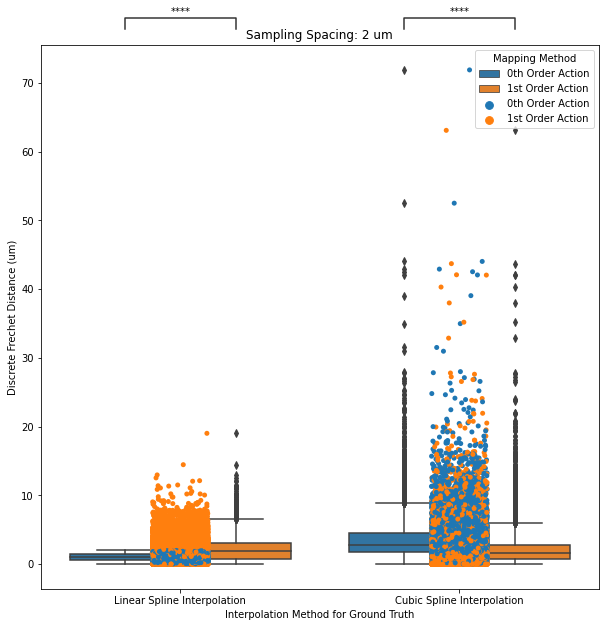

In [18]:
data = {"Mapping Method": methods, "Discrete Frechet Distance (um)": errors, "Interpolation Method for Ground Truth": truths}
df = pd.DataFrame(data=data)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

fig_args = {
    "y": "Discrete Frechet Distance (um)",
    "x": "Interpolation Method for Ground Truth",
    "hue": "Mapping Method",
    "data": df,
}
pairs = [(("Linear Spline Interpolation", "0th Order Action"), ("Linear Spline Interpolation", "1st Order Action")), (("Cubic Spline Interpolation", "0th Order Action"), ("Cubic Spline Interpolation", "1st Order Action"))]

annotator = Annotator(ax, pairs, **fig_args)
#annotator.configure(comparisons_correction="Bonferroni")

sns.boxplot(ax=ax, **fig_args)#, boxprops=dict(alpha=.3))
splot = sns.stripplot(ax=ax, **fig_args)
annotator.configure(test="Wilcoxon", text_format="star", loc="outside")
annotator.new_plot(splot, plot="stripplot", **fig_args)
annotator.apply_and_annotate()
ax.set_title(f"Sampling Spacing: {spacing} um")
plt.show()

### Debug multiple vertices

In [ ]:
print(f"id: {id}")
verts = skel.vertices
rows, invs, counts = np.unique(verts, axis=0, return_counts = True, return_inverse = True) #inv has the places of indexes of rows
wher = np.squeeze(np.argwhere(counts > 1)) #identify which index in counts/rows has multiple instances
np.where(invs == wher)



In [ ]:
vol_atlas = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
shp_atlas = np.array(vol_atlas.shape)
res_atlas = np.array(vol_atlas.resolution)/1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# Downsample

## Downsample vs Accuracy

In [19]:
vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/axons")
shp = np.array(vol.shape)
res_im = np.array(vol.resolution)/1000
origin_im = (shp[:3] - 1) * res_im / 2

valid_ids = []
for i in range(100):
    try:
        vol.skeleton.get(i)
    except SkeletonDecodeError:
        continue
    valid_ids.append(i)

print(f"Valid IDs: {valid_ids}")

Valid IDs: [1, 4, 11, 12, 13, 14, 20, 35, 40, 45, 48, 49, 51, 53, 59, 60, 65]


In [59]:
methods = []
errors = []
av_sample_distances = []

spacing = 2
inter = 65
ds_factor = 2

In [60]:
intermediate_data = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/derivdiff2_errsthru{inter}_spac{spacing}_ds{ds_factor}.pickle"

with open(intermediate_data, 'rb') as handle:
    data = pickle.load(handle)

methods = data["Method"]
errors = data["Frechet Distance"]
av_sample_distances = data["Average Sampling"]

print(len(av_sample_distances))

22984


In [4]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_v.mat",
"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_A.mat")

integrating velocity field: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Zeroth Order error: 16.627213594925085 with av sample dist: 71.95937406998539
First Order error: 6.79401753098562 with av sample dist: 71.95937406998539
1169


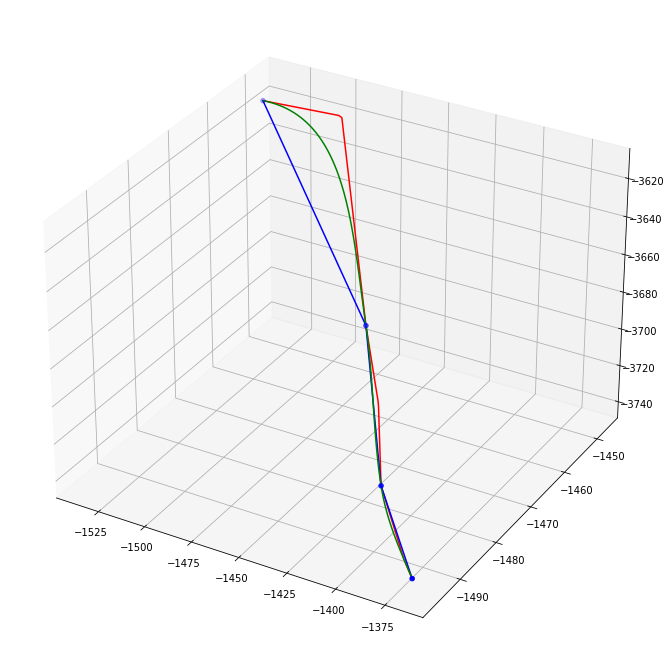

In [35]:
for id in tqdm(valid_ids, desc="Processing neurons..."):
    if id <= inter:
        continue

    # get coords in proper cooordinates
    skel = vol.skeleton.get(id)
    coords = skel.vertices/1000 - origin_im

    # apply affine transform
    coords = ct.apply_affine(coords)

    G_neuron = GeometricGraph()
    for node_id, coord in enumerate(coords):
        G_neuron.add_node(node_id, loc=coord)
    for edge in skel.edges:
        G_neuron.add_edge(edge[0], edge[1])

    if id == 20:
        G_neuron.remove_node(4957)
        G_neuron.add_edge(4956, 4958)
    if id == 53:
        G_neuron.remove_node(0)

    spline_tree = G_neuron.fit_spline_tree_invariant()

    # For each branch
    for node in tqdm(spline_tree.nodes, desc="Processing branches...", leave=False):
        # Create geometric graph for the branch
        path = spline_tree.nodes[node]["path"]
        x = []
        y = []
        z = []
        s = []
        p = [-1]

        for node_i, node in enumerate(path):
            loc = G_neuron.nodes[node]["loc"]
            x.append(loc[0])
            y.append(loc[1])
            z.append(loc[2])
            s.append(node_i)
            if node_i > 0:
                p.append(node_i-1)

        
        dict = {"x": x, "y": y, "z": z, "sample": s, "parent": p}
        df = pd.DataFrame(data = dict)
        G_branch = GeometricGraph(df = df, root = s[0])
        G_branch.fit_spline_tree_invariant()
        spline_tree_branch = G_branch.spline_tree

        # downsample
        nodes2keep = [node_i for node_i in range(0, len(s), ds_factor)]
        if s[-1] not in nodes2keep:
            nodes2keep += [s[-1]]
        nodes2remove = [node_i for node_i in s if node_i not in nodes2keep]

        path = spline_tree_branch.nodes[0]["path"]
        tck, us = spline_tree_branch.nodes[0]["spline"]
        positions = np.array(splev(us, tck, der=0)).T
        derivs = compute_derivs(us, tck, positions)

        G_branch_ds = deepcopy(G_branch)
        G_branch_ds.remove_nodes_from(nodes2remove)
        G_branch_ds.remove_edges_from(list(G_branch.edges))
        for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
            G_branch_ds.add_edge(node1,node2)
        derivs = np.delete(derivs, nodes2remove, 0)
        G_branch_ds.fit_spline_tree_invariant(k=1)
        spline_tree_branch_ds = G_branch_ds.spline_tree

        # transform the branch
        G_branch_transformed = deepcopy(G_branch)
        G_branch_ds_transformed = deepcopy(G_branch_ds)
        # G_branch_transformed = transform_GeometricGraph(G_branch_transformed, ct, deriv_method="difference")
        G_branch_ds_transformed = transform_GeometricGraph(G_branch_ds_transformed, ct, derivs = derivs)

        spline_tree_transformed = G_branch_transformed.spline_tree
        spline_tree_transformed_ds = G_branch_ds_transformed.spline_tree
        
        if len(spline_tree_transformed_ds.nodes) != 1:
            raise ValueError("transformed spline tree does not have 1 branch")

        # Compute sampling length from downsampled branch
        spline = spline_tree_branch_ds.nodes[0]["spline"]
        u = spline[1]
        tck = spline[0]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

        # Access original knots and compute sample distance
        spline = spline_tree_branch.nodes[0]["spline"]
        u = spline[1]
        tck = spline[0]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)

        # Find dense line points
        tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
        u_dense = np.arange(u[0], u[-1], spacing)
        u_dense = np.append(u_dense, u[-1])
        pts_line = splev(u_dense, tck_line)
        pts_line = np.stack(pts_line, axis=1)
        dense_line_pts = ct.evaluate(pts_line)

        # Find transformed knots
        spline = spline_tree_transformed_ds.nodes[0]["spline"]
        chspline = spline[0]
        u = spline[1]
        u_first_order = np.arange(u[0], u[-1], spacing)
        u_first_order = np.append(u_first_order, u[-1])
        trans_pts = chspline(u)

        #print("0th Order Mapping...")
        u_line = compute_parameterization(trans_pts)
        tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
        u_line = np.arange(u_line[0], u_line[-1], spacing)
        u_line = np.append(u_line, u[-1])
        zero_order_pts = splev(u_line, tck_line)
        zero_order_pts = np.stack(zero_order_pts, axis=1)

        #print("1st order mapping...")
        first_order_pts = chspline(u_first_order)  

        for method, method_pts in zip(["Zeroth Order", "First Order"], [zero_order_pts, first_order_pts]):
            error = frechet_dist(dense_line_pts, method_pts)

            av_sample_distances.append(av_sample_distance)
            errors.append(error)
            methods.append(method)
            #print(f"{method} error: {error} with av sample dist: {av_sample_distance}")
        # print(f"{node}")
        # fig = plt.figure(figsize=(12, 12))
        # ax = fig.add_subplot(111, projection="3d")
        # ax.plot(dense_line_pts[:,0],dense_line_pts[:,1],dense_line_pts[:,2], c='red', label="Continuous Mapping (Ground Truth)")
        # ax.plot(zero_order_pts[:,0],zero_order_pts[:,1],zero_order_pts[:,2], c='blue', label="Discrete Mapping - 0th Order")
        # ax.scatter(trans_pts[:,0],trans_pts[:,1],trans_pts[:,2], c='blue')
        # ax.plot(first_order_pts[:,0],first_order_pts[:,1],first_order_pts[:,2], c='green', label="Discrete Mapping - 1st Order")
        # plt.show()

    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/derivdiff2_errsthru{id}_spac{spacing}_ds{ds_factor}.pickle"
    data = {"Method": methods, "Frechet Distance": errors, "Average Sampling": av_sample_distances}
    with open(fname, 'wb') as handle:
        pickle.dump(data, handle)

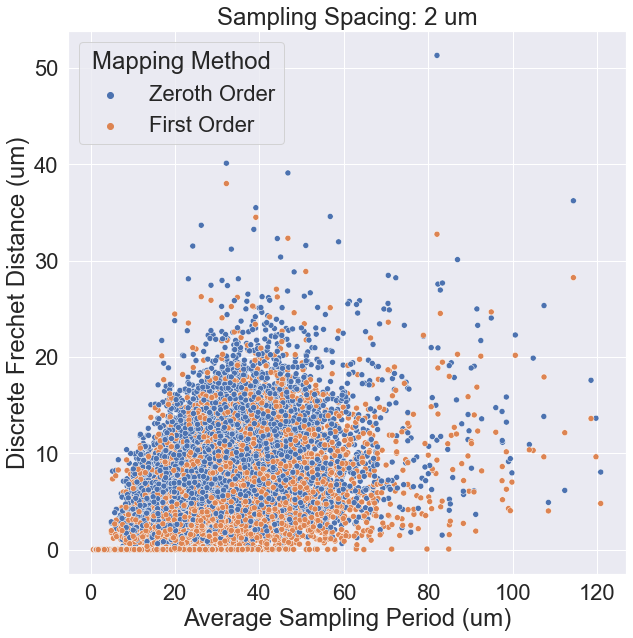

In [61]:
data = {"Mapping Method": methods, "Discrete Frechet Distance (um)": errors, "Average Sampling Period (um)": av_sample_distances}
df = pd.DataFrame(data=data)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

fig_args = {
    "y": "Discrete Frechet Distance (um)",
    "x": "Average Sampling Period (um)",
    "hue": "Mapping Method",
    "data": df,
}

sns.scatterplot(ax=ax, **fig_args)#, boxprops=dict(alpha=.3))
ax.set_title(f"Sampling Spacing: {spacing} um")
#ax.set(xscale="log", yscale="log")
plt.show()


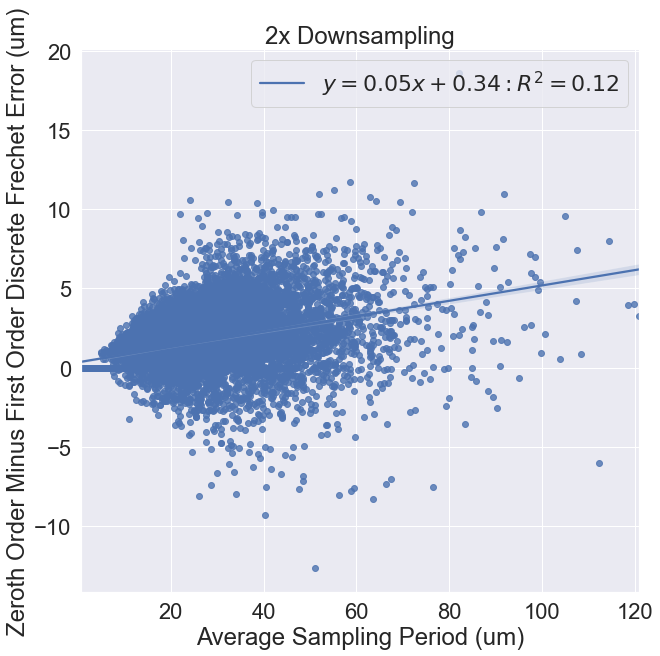

WilcoxonResult(statistic=4811377.0, pvalue=0.0)
(0.348026486373212, 0.0)


In [62]:
for i in range(0, len(errors)-1, 2):
    if errors[i] == 0 and errors[i+1] != 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")
    elif errors[i] != 0 and errors[i+1] == 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")

error_difs = [errors[i] - errors[i+1] for i in range(0, len(errors)-1, 2)]
#error_difs = [errors[i] / errors[i+1] if errors[i+1] != 0 else 1 for i in range(0, len(errors)-1, 2)]
av_sample_distances_2 = [av_sample_distances[i] for i in range(0, len(errors)-1, 2)]


indep_var = "Zeroth Order Minus First Order Discrete Frechet Error (um)"
#indep_var = "Ratio of Zeroth to First Order Discrete Frechet Error (um)"

data = {indep_var: error_difs, "Average Sampling Period (um)": av_sample_distances_2}
df = pd.DataFrame(data=data)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)



slope, intercept, r_value, p_value, std_err = linregress(df["Average Sampling Period (um)"],df[indep_var])
if intercept < 0:
    symbol = "-"
else:
    symbol = "+"

line_kws = {'label': f"$y={slope:.2f}x{symbol}{np.abs(intercept):.2f}: R^2= {r_value**2:.2f}$"}
fig_args = {
    "y": indep_var,
    "x": "Average Sampling Period (um)",
    "data": df,
}

sns.set(font_scale = 2)

sns.regplot(ax=ax, line_kws = line_kws, **fig_args)#, boxprops=dict(alpha=.3))
ax.set_title(f"2x Downsampling")
#ax.set(xscale="log", yscale="log")
plt.legend()
plt.show()

print(wilcoxon(error_difs))

print(pearsonr(df[indep_var].to_numpy(),df["Average Sampling Period (um)"].to_numpy()))

## Downsample Neuron Phenomena

Zeroth Order error: 16.627213594925085 with av sample dist: 71.95937406998539
First Order error: 6.79401753098562 with av sample dist: 71.95937406998539


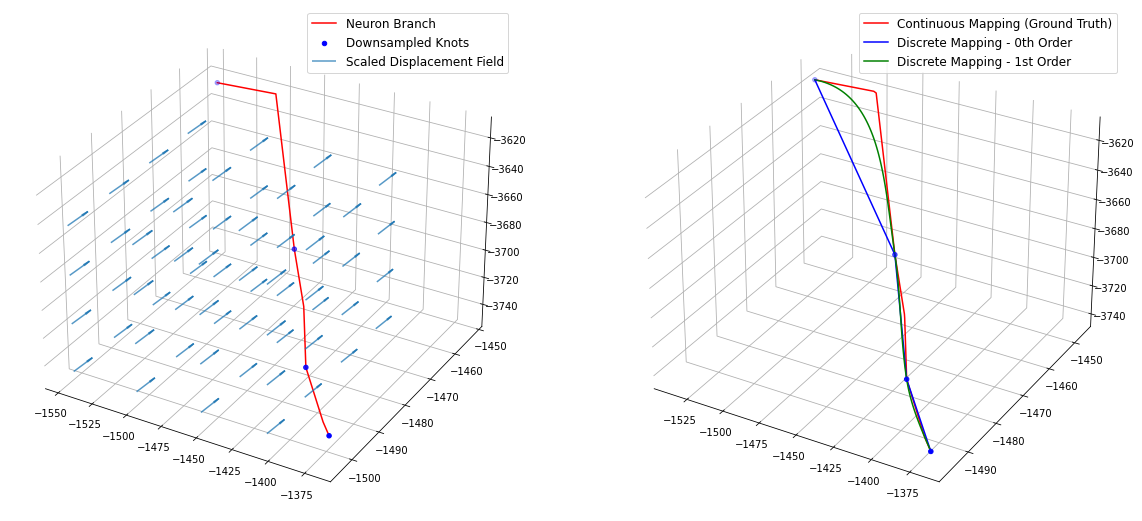

In [14]:

neuron_id = 1
branch_id = 97

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices/1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G_neuron = GeometricGraph()
for node_id, coord in enumerate(coords):
    G_neuron.add_node(node_id, loc=coord)
for edge in skel.edges:
    G_neuron.add_edge(edge[0], edge[1])

if id == 20:
    G_neuron.remove_node(4957)
    G_neuron.add_edge(4956, 4958)
if id == 53:
    G_neuron.remove_node(0)

spline_tree = G_neuron.fit_spline_tree_invariant()


path = spline_tree.nodes[branch_id]["path"]
x = []
y = []
z = []
s = []
p = [-1]

for node_i, node in enumerate(path):
    loc = G_neuron.nodes[node]["loc"]
    x.append(loc[0])
    y.append(loc[1])
    z.append(loc[2])
    s.append(node_i)
    if node_i > 0:
        p.append(node_i-1)


dict = {"x": x, "y": y, "z": z, "sample": s, "parent": p}
df = pd.DataFrame(data = dict)
G_branch = GeometricGraph(df = df, root = s[0])
G_branch.fit_spline_tree_invariant()
spline_tree_branch = G_branch.spline_tree

# downsample
nodes2keep = [node_i for node_i in range(0, len(s), ds_factor)]
if s[-1] not in nodes2keep:
    nodes2keep += [s[-1]]
nodes2remove = [node_i for node_i in s if node_i not in nodes2keep]

path = spline_tree_branch.nodes[0]["path"]
tck, us = spline_tree_branch.nodes[0]["spline"]
positions = np.array(splev(us, tck, der=0)).T
derivs = compute_derivs(us, tck, positions)

G_branch_ds = deepcopy(G_branch)
G_branch_ds.remove_nodes_from(nodes2remove)
G_branch_ds.remove_edges_from(list(G_branch.edges))
for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
    G_branch_ds.add_edge(node1,node2)
derivs = np.delete(derivs, nodes2remove, 0)
G_branch_ds.fit_spline_tree_invariant(k=1)
spline_tree_branch_ds = G_branch_ds.spline_tree

# transform the branch
G_branch_transformed = deepcopy(G_branch)
G_branch_ds_transformed = deepcopy(G_branch_ds)
# G_branch_transformed = transform_GeometricGraph(G_branch_transformed, ct, deriv_method="difference")
G_branch_ds_transformed = transform_GeometricGraph(G_branch_ds_transformed, ct, derivs = derivs)

spline_tree_transformed = G_branch_transformed.spline_tree
spline_tree_transformed_ds = G_branch_ds_transformed.spline_tree

if len(spline_tree_transformed_ds.nodes) != 1:
    raise ValueError("transformed spline tree does not have 1 branch")

# Compute sampling length from downsampled branch
spline = spline_tree_branch_ds.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)
av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

# Access original knots and compute sample distance
spline = spline_tree_branch.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)

# Find dense line points
tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
u_dense = np.arange(u[0], u[-1], spacing)
u_dense = np.append(u_dense, u[-1])
pts_line = splev(u_dense, tck_line)
pts_line = np.stack(pts_line, axis=1)
dense_line_pts = ct.evaluate(pts_line)

# Find transformed knots
spline = spline_tree_transformed_ds.nodes[0]["spline"]
chspline = spline[0]
u = spline[1]
u_first_order = np.arange(u[0], u[-1], spacing)
u_first_order = np.append(u_first_order, u[-1])
trans_pts = chspline(u)

#print("0th Order Mapping...")
u_line = compute_parameterization(trans_pts)
tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
u_line = np.arange(u_line[0], u_line[-1], spacing)
u_line = np.append(u_line, u[-1])
zero_order_pts = splev(u_line, tck_line)
zero_order_pts = np.stack(zero_order_pts, axis=1)

#print("1st order mapping...")
first_order_pts = chspline(u_first_order)  

for method, method_pts in zip(["Zeroth Order", "First Order"], [zero_order_pts, first_order_pts]):
    error = frechet_dist(dense_line_pts, method_pts)

    av_sample_distances.append(av_sample_distance)
    errors.append(error)
    methods.append(method)
    print(f"{method} error: {error} with av sample dist: {av_sample_distance}")

# Target soace

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-', label="Neuron Branch", color="red")


spline = G_branch_ds.spline_tree.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts_ds = splev(u, tck)
pts_ds = np.stack(pts_ds, axis=1)
ax.scatter(pts_ds[:,0], pts_ds[:,1], pts_ds[:,2], label="Downsampled Knots", color="blue")
    
# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], displacements[:,0],displacements[:,1],displacements[:,2], length=1, label="Scaled Displacement Field", alpha=0.75) #length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.legend(fontsize=12)

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.plot(dense_line_pts[:,0],dense_line_pts[:,1],dense_line_pts[:,2], c='red', label="Continuous Mapping (Ground Truth)")
ax.plot(zero_order_pts[:,0],zero_order_pts[:,1],zero_order_pts[:,2], c='blue', label="Discrete Mapping - 0th Order")
ax.scatter(trans_pts[:,0],trans_pts[:,1],trans_pts[:,2], c='blue')
ax.plot(first_order_pts[:,0],first_order_pts[:,1],first_order_pts[:,2], c='green', label="Discrete Mapping - 1st Order")
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)
plt.show()


## Downsample

In [ ]:
dict = {"x": [0, -0.7, -1, -1], "y": [-1, -0.25, 0.25, 1], "z": [0, 0, 0.25, 1], "sample": [1,2, 3, 4], "parent": [-1, 1, 2, 3]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Simple Curve", c="red")
    ax.scatter(pts[0], pts[1], pts[2], c="red")

    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)

    #ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

# Generate transformation
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1, 0.4, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [0.5])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)

ax.quiver(x, y, z, u, v, w, length=0.2, label="Scaled Displacement Field")

ax.legend(fontsize=17)
ax.axes.set_xlim3d(left=-1, right=0.25) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

In [ ]:
path = spline_tree.nodes[0]["path"]
tck, us = spline_tree.nodes[0]["spline"]
positions = np.array(splev(us, tck, der=0)).T
derivs = compute_derivs(us, tck, positions)

In [ ]:
node2remove = 2

H = deepcopy(G)
H.remove_node(node2remove)
H.add_edge(node2remove-1,node2remove+1)
derivs = np.delete(derivs, node2remove, 0)
print(derivs)
H.fit_spline_tree_invariant(k=1)

In [ ]:
diff = Gaussian_1()
G_transformed = deepcopy(G)
G_transformed = transform_GeometricGraph(G_transformed, diff)
H_transformed = deepcopy(H)
H_transformed = transform_GeometricGraph(H_transformed, diff, derivs = derivs)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

#act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    #dense spline points
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Continuous Mapping (Ground Truth)", c='red')

#act on dense points
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    #trace points only
    u = spline[1]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 0th Order", c='blue')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], c='red')

#act on derivatives
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="Discrete Mapping - 1st Order", c='green')
    
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.legend(fontsize=17)
ax.axes.set_xlim3d(left=-1, right=0.25) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

## Downsample swirl

In [ ]:
t = np.arange(0, 6*np.pi, 0.1)

x = 0.05*t*np.cos(t) - 0.5
y = 0.05*t*np.sin(t)
z = 0*t + 0.5

dict = {"x": x, "y": y, "z": z, "sample": [i for i in range(len(t))], "parent": [-1] + [i for i in range(len(t)-1)]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df, root = 0)

nodes2keep = [i for i in range(0, len(t), 5)]
if len(t)-1 not in nodes2keep:
    nodes2keep += [len(t)-1]
print(f"nodes to keep: {nodes2keep}")
nodes2remove = [i for i in range(len(t)) if i not in nodes2keep]
print(f"nodes t o remove: {nodes2remove}")
G.fit_spline_tree_invariant()
spline_tree = G.spline_tree

In [ ]:
from scipy.stats import norm

#only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        transformed_position[:,0] += norm.pdf(transformed_position[:,1], scale = 0.5)
        
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv

#move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self):
        pass
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[0,1] = norm.pdf(pos[1], scale = 0.5)*(-4*pos[1])
            transformed_deriv[i,:] = np.matmul(J, d).T

        return transformed_deriv


In [ ]:
path = spline_tree.nodes[0]["path"]
tck, us = spline_tree.nodes[0]["spline"]
positions = np.array(splev(us, tck, der=0)).T
derivs = compute_derivs(us, tck, positions)
# print(f"first derivaticves: {derivs[:5,:]}")
# print(f"derivs shape: {derivs.shape}")
# print(f"path:  {path}")
# print(f"nodes in G: {G.nodes}")

In [ ]:
import networkx as nx

H = deepcopy(G)

H.remove_nodes_from(nodes2remove)
H.remove_edges_from(list(G.edges))

for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
    H.add_edge(node1,node2)


derivs = np.delete(derivs, nodes2remove, 0)

H.fit_spline_tree_invariant(k=1)

In [ ]:
diff = Gaussian_1()
G_transformed = deepcopy(G)
G_transformed = transform_GeometricGraph(G_transformed, diff)
H_transformed = deepcopy(H)
H_transformed = transform_GeometricGraph(H_transformed, diff, derivs = derivs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

## Before
ax = ax1 

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)
for node in tqdm(spline_tree.nodes, desc="Processing branches"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    # ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Simple Curve", c="red")
    # ax.scatter(pts[0], pts[1], pts[2], c="red")
    ax.plot(pts[0], pts[1], linestyle='-',linewidth=0.8, label="Simple Curve", c="red")
    #ax.scatter(pts[0], pts[1], c="red")

    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)

    #ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)

xs_ds = []
ys_ds = []
for node2keep in nodes2keep:
    xs_ds.append(G.nodes[node2keep]['loc'][0])
    ys_ds.append(G.nodes[node2keep]['loc'][1])
ax.scatter(xs_ds, ys_ds, c="blue", label="Discrete Sampling")

ax.grid(True)

# Generate transformation
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1.25, 0.4, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [0.5])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)


ax.quiver(np.squeeze(x), np.squeeze(y), np.squeeze(u), np.squeeze(v), color='green', label="Scaled Displacement Field")

ax.legend(fontsize=17)


## After
ax = ax2

#act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # knots only
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    #ax.scatter(trans_pts[:,0], trans_pts[:,1], c='red')


    #dense spline points
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], linestyle='-',linewidth=0.8, label="Continuous Mapping (Ground Truth)", c='red')

#act on dense points
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    #trace points only
    u = spline[1]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], linestyle='-',linewidth=0.8, label="Discrete Mapping - 0th Order", c='blue')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], c='blue')

#act on derivatives
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.005, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], linestyle='-',linewidth=0.8, label="Discrete Mapping - 1st Order", c='green')
    

ax.grid(True)
plt.legend(fontsize=17)
# ax.axes.set_xlim3d(left=-1, right=0.25) 
# ax.axes.set_ylim3d(bottom=-1, top=1) 
# ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

## Downsample Tree

In [ ]:
t1 = np.arange(-1, 1.01, 0.01)
x1 = 0*t1 - 0.5
y1 = t1
z1 = 0*t1
p1 = [-1] + [i for i in range(len(t1)-1)]
s1 = [i for i in range(len(t1))]
dict = {"x": x1, "y": y1, "z": z1, "sample": s1, "parent": p1}
df = pd.DataFrame(data = dict)
G1 = GeometricGraph(df = df, root = 0)
nodes2keep1 = [0, 30, 60, 90, 100, 130, 150, 180]
nodes2keep1 += [len(t1)-1]
nodes2remove1 = [i for i in range(len(t1)) if i not in nodes2keep1]
G1.fit_spline_tree_invariant()

t2 = np.arange(0, 0.9, 0.01)
x2 = t2 - 0.5
y2 = t2**2
z2 = 0*t2
p2 = [-1] + [i for i in range(len(t2)-1)]
s2 = [i for i in range(len(t2))]
dict = {"x": x2, "y": y2, "z": z2, "sample": s2, "parent": p2}
df = pd.DataFrame(data = dict)
G2 = GeometricGraph(df = df, root = 0)
nodes2keep2 = [0, 30, 60]
nodes2keep2 += [len(t2)-1]
nodes2remove2 = [i for i in range(len(t2)) if i not in nodes2keep2]
G2.fit_spline_tree_invariant()

t3 = np.arange(0, 0.5, 0.01)
x3 = -t3 - 0.5
y3 = 0.5 + 0.5*np.sqrt(t3)
z3 = 0*t3
p3 = [-1] + [i for i in range(len(t3)-1)]
s3 = [i for i in range(len(t3))]
dict = {"x": x3, "y": y3, "z": z3, "sample": s3, "parent": p3}
df = pd.DataFrame(data = dict)
G3 = GeometricGraph(df = df, root = 0)
nodes2keep3 = [0, 30]
nodes2keep3 += [len(t3)-1]
nodes2remove3 = [i for i in range(len(t3)) if i not in nodes2keep3]
G3.fit_spline_tree_invariant()


In [ ]:
from scipy.stats import norm

#only move points
class Rotate(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        theta = np.arctan2(position[:,1], position[:,0])
        r = np.linalg.norm(position, axis=1)

        transformed_position = position.copy()
        transformed_position[:,0] = np.multiply(r, np.cos(theta+r))
        transformed_position[:,1] = np.multiply(r, np.sin(theta+r))
        
        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)

            x = pos[0]
            y = pos[1]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])

            if r > 0:
                J[0,0] = x/r*np.cos(theta+r) - r*np.sin(theta+r) * (x/r-y/(x**2+y**2))
                J[0,1] = y/r*np.cos(theta+r)-r*np.sin(theta+r)*(y/r+x/(x**2+y**2))

                J[1,0] = x/r*np.sin(theta+r) + r*np.cos(theta+r)*(x/r-y/(x**2+y**2))
                J[1,1] = y/r*np.sin(theta+r) + r*np.cos(theta+r)*(y/r+x/(x**2+y**2))
            
            transformed_deriv[i,:] = np.matmul(J, d).T

        return transformed_deriv


In [ ]:
H_transformeds = []
Hs = []

for G, nodes2keep, nodes2remove in zip([G1, G2, G3], [nodes2keep1, nodes2keep2, nodes2keep3], [nodes2remove1, nodes2remove2, nodes2remove3]):
    spline_tree = G.spline_tree
    path = spline_tree.nodes[0]["path"]
    tck, us = spline_tree.nodes[0]["spline"]
    positions = np.array(splev(us, tck, der=0)).T
    derivs = compute_derivs(us, tck, positions)

    H = deepcopy(G)

    H.remove_nodes_from(nodes2remove)
    H.remove_edges_from(list(G.edges))

    for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
        H.add_edge(node1,node2)


    derivs = np.delete(derivs, nodes2remove, 0)

    H.fit_spline_tree_invariant(k=1)

    diff = Rotate()
    G_transformed = deepcopy(G)
    G_transformed = transform_GeometricGraph(G_transformed, diff)
    H_transformed = deepcopy(H)
    H_transformed = transform_GeometricGraph(H_transformed, diff, derivs = derivs)
    H_transformeds.append(H_transformed)
    Hs.append(H)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

## Before
ax = ax1

for b,G in enumerate([G1, G2, G3]):
    spline_tree = G.fit_spline_tree_invariant(k=1)
    spline = spline_tree.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    # ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Simple Curve", c="red")
    # ax.scatter(pts[0], pts[1], pts[2], c="red")
    if b == 0:
        label = "Simple Curve"
    else:
        label = None
    ax.plot(pts[0], pts[1], linestyle='-',linewidth=0.8, c="red", label=label)
    #ax.scatter(pts[0], pts[1], c="red")

    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)

    #ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)


xs_ds = []
ys_ds = []
for G, nodes2keep in zip([G1, G2, G3], [nodes2keep1, nodes2keep2, nodes2keep3]):
    for node2keep in nodes2keep:
        xs_ds.append(G.nodes[node2keep]['loc'][0])
        ys_ds.append(G.nodes[node2keep]['loc'][1])
ax.scatter(xs_ds, ys_ds, c="blue", label="Discrete Sampling")

ax.grid(True)

# Generate transformation
diff = Rotate()

x, y, z = np.meshgrid(np.arange(-1.25, 0.4, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [0.5])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)


ax.quiver(np.squeeze(x), np.squeeze(y), np.squeeze(u), np.squeeze(v), color='green', label="Scaled Displacement Field")

ax.legend(fontsize=17)


## After

ax = ax2

for b, (G, H_transformed, H) in enumerate(zip([G1, G2, G3], H_transformeds, Hs)):
    if b == 0:
        lbl1 = "Continuous Mapping (Ground Truth)"
        lbl2 = "Discrete Mapping - 0th Order"
        lbl3 = "Discrete Mapping - 1st Order"
    else:
        lbl1 = None
        lbl2 = None
        lbl3 = None
    #act on dense points
    spline_tree = G.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        tck = spline[0]

        # knots only
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)
        #ax.scatter(trans_pts[:,0], trans_pts[:,1], c='red')

        #dense spline points
        u = np.arange(u[0], u[-1]+0.005, 0.01)
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)
        ax.plot(trans_pts[:,0], trans_pts[:,1], linestyle='-',linewidth=0.8, label=lbl1, c='red')

    #act on dense points
    soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
    spline_tree = H.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        tck = spline[0]

        #trace points only
        u = spline[1]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)
        ax.plot(trans_pts[:,0], trans_pts[:,1], linestyle='-',linewidth=0.8, label=lbl2, c='blue')
        ax.scatter(trans_pts[:,0], trans_pts[:,1], c='blue')

    #act on derivatives
    soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
    spline_tree = H_transformed.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        u = np.arange(u[0], u[-1]+0.005, 0.01)
        chspline = spline[0]
        pts = chspline(u)

        ax.plot(pts[:,0], pts[:,1], linestyle='-',linewidth=0.8, label=lbl3, c='green')
        

ax.grid(True)
plt.legend(fontsize=17)
# ax.axes.set_xlim3d(left=-1, right=0.25) 
# ax.axes.set_ylim3d(bottom=-1, top=1) 
# ax.axes.set_zlim3d(bottom=0, top=1) 
plt.show()

## Linear Transformation

In [ ]:
class LinearTransformation(DiffeomorphismAction):
    def __init__(self, A, b):
        self.A = A
        self.b =  b

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = np.matmul(self.A, position.T).T
        transformed_position = np.add(transformed_position, self.b)
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = np.matmul(self.A, deriv.T).T
        return transformed_deriv


## Real Neuron

In [ ]:
brainlit_path=Path.cwd().parent.parent.parent
swc=Path.joinpath(brainlit_path,'data','data_octree','consensus-swcs','2018-08-01_G-002_consensus.swc')
nt = NeuronTrace(path=str(swc))
df = nt.get_df()
neuron = GeometricGraph(df=df)


In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
soma = np.array(neuron.nodes[neuron.root]["loc"])
spline_tree = neuron.fit_spline_tree_invariant()
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    u = np.arange(u[0], u[-1]+0.1, 0.1)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',color='midnightblue',linewidth=0.8, label="Mapping Dense Points")

ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)


plt.show()

In [ ]:
diff = LinearTransformation(A = np.array([[2,0,0],[0,1,0],[0,0,1]]), b = [1000,0,0])
neuron_tranformed = transform_GeometricGraph(neuron, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
soma = np.array(neuron_tranformed.nodes[neuron.root]["loc"])
spline_tree = neuron_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.1, 0.1)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',color='midnightblue',linewidth=0.8, label="Mapping Endpoints and Derivatives")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)


plt.show()